In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from functools import partial
from copy import deepcopy
from toolz import compose, valmap, keyfilter, identity, merge
from itertools import combinations
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

import sbi
import sbi.utils
import sbi.inference
import sbi.analysis

import sbibm
import sbibm.tasks.eggbox
import sbibm.tasks.eggbox.posterior
# import sbibm.tasks.rotated_eggbox.posterior as REP

import scipy
import scipy.stats
import scipy.linalg

import swyft
import swyft.utils.constrainedcorner as cc

import tmnre
import tmnre.metrics
import tmnre.benchmark
import tmnre.coverage.oned
from tmnre.nn.resnet import make_resenet_tail
from tmnre.marginalize import filter_marginals_by_dim

import corner

# Linear algebra to the rescue

https://math.stackexchange.com/questions/598750/finding-the-rotation-matrix-in-n-dimensions/598782

One way to do this is to find two orthonormal vectors in the plane generated by your two vectors, and then extend it to an orthonormal basis of $\mathbb R^n$.  Then with respect to this basis, consider the rotation by angle $\theta$ in the plan generated by the first two vectors, and the identity on the space generated by the rest of the orthonormal basis.  Use Gram-Schmidt to find the orthonormal basis.

As you said in a previous comment, you cannot rotate around an axis except in 3D.  Rather you need to rotate about an $n-2$-dimensional subspace.

So suppose you want to rotate $x$ to $y$, and you happen to know they are the same norm.  Let $u = x/|x|$, and $v = (y-(u.y)u)/|y-(u.y)u|$.  Then $P=uu^T + vv^T$ is a projection onto the space generated by $x$ and $y$, and $Q=I-uu^T-vv^T$ is the projection onto the $n-2$-dimensional complemented subspace.  So the "rotation" part just has to take place on the range of $P$.  That is, $z \mapsto (z.u,z.v)$ is a isomorphic isometry of the range of $P$ to $\mathbb R^2$.  Do the rotation on $\mathbb R^2$.  Then map this back to $\mathbb R^n$ by $[a,b]^T \mapsto au + bv$.

So the whole rotation is
$$ I - uu^T -vv^T + [u\ v]R_\theta[u\ v]^T $$
where
$$ R_\theta = \begin{bmatrix}\cos(\theta) & -\sin(\theta) \\ \sin(\theta & \cos(\theta) \end{bmatrix} $$
where $\cos(\theta) = x\cdot y/(|x||y|)$.

(By the way, if a reflection matrix is OK, then consider Householder transformations instead.)

Here is some MATLAB code (but tested using octave so maybe it has syntax errors in matlab).

```matlab
x=[2,4,5,3,6]';
y=[6,2,0,1,7]';
u=x/norm(x);
v=y-u'*y*u;
v=v/norm(v);
cost=x'*y/norm(x)/norm(y);
sint=sqrt(1-cost^2);
R = eye(length(x))-u*u'-v*v' + [u v]* [cost -sint;sint cost] *[u v]';
fprintf('testing\n');
should_be_identity = R*R'
should_be_y = R*x
```

In [3]:
d = 10

# We aim to rotate x to y
x = np.ones((d, 1))
y = np.zeros((d, 1))
y[-1, :] = 1.
print(x)
print(y)

# Create orthonormal basis for the planar subspace
u = x / np.linalg.norm(x)
v = (y - np.dot(u.T, y) * u)
v /= np.linalg.norm(v)

# Create rotation matrix within planar subspace
cos_theta = np.dot(x.T, y).flatten() / (np.linalg.norm(x) * np.linalg.norm(y))
sin_theta = np.sqrt(1 - cos_theta ** 2)
R_theta = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]]).squeeze()
uv = np.concatenate([u, v], axis=-1)

# Assemble total rotation (I - uu' - vv') + ([u, v] R [u, v].T) == Project onto complement + project onto rotated planar subspace
Q = np.eye(d) - np.dot(u, u.T) - np.dot(v, v.T) + uv @ R_theta @ uv.T

print(np.round(Q @ x, 4))
print(np.linalg.det(Q))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]
[[0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [3.1623]]
1.0000000000000004


In [4]:
# positions of (some) eggbox mass
eb = compose(np.tril, np.ones)((d, d)) * 2 - 1
ebQ = Q @ eb
print(np.round(ebQ, 1))
print(np.linalg.norm(ebQ, axis=1))

[[ 0.  -1.8 -1.7 -1.5 -1.4 -1.2 -1.1 -0.9 -0.8 -0.6]
 [ 0.   0.2 -1.7 -1.5 -1.4 -1.2 -1.1 -0.9 -0.8 -0.6]
 [ 0.   0.2  0.3 -1.5 -1.4 -1.2 -1.1 -0.9 -0.8 -0.6]
 [ 0.   0.2  0.3  0.5 -1.4 -1.2 -1.1 -0.9 -0.8 -0.6]
 [ 0.   0.2  0.3  0.5  0.6 -1.2 -1.1 -0.9 -0.8 -0.6]
 [ 0.   0.2  0.3  0.5  0.6  0.8 -1.1 -0.9 -0.8 -0.6]
 [ 0.   0.2  0.3  0.5  0.6  0.8  0.9 -0.9 -0.8 -0.6]
 [ 0.   0.2  0.3  0.5  0.6  0.8  0.9  1.1 -0.8 -0.6]
 [ 0.   0.2  0.3  0.5  0.6  0.8  0.9  1.1  1.2 -0.6]
 [ 3.2  2.5  1.9  1.3  0.6  0.  -0.6 -1.3 -1.9 -2.5]]
[3.90248205 3.44051793 3.00878027 2.62224167 2.30376681 2.08478518
 1.99827788 2.06099424 2.26054808 5.83095189]


In [5]:
TASK_NAME = "eggbox"
NUM_OBS = 1
DIM = 10
N_SIMULATIONS = 10_000
N_POSTERIOR_SAMPLES = 25_000
N_JOBS = 12

task = sbibm.get_task(
    TASK_NAME,
    dim=DIM,
)

theta0 = task.get_true_parameters(NUM_OBS).squeeze()
obs0 = task.get_observation(NUM_OBS).squeeze()
print(theta0)
print(obs0)
ps = task.get_reference_posterior_samples(NUM_OBS).numpy()
print(ps.shape)

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500])
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])
(10000, 10)


In [6]:
# We also have to figure out our new uniform dist.
# Look at where the corners of the uniform distribution got rotated to.
# Find a box which encapsulates all of them

from itertools import product

box_corners = np.asarray(list(product([0., 1.], repeat=10))).T
upper_bounds = (Q @ box_corners).max(axis=1).tolist()
lower_bounds = (Q @ box_corners).min(axis=1).tolist()
bounds = list(zip(lower_bounds, upper_bounds))
bounds

[(-0.9240253073352042, 0.9240253073352043),
 (-0.9240253073352042, 0.9240253073352043),
 (-0.9240253073352042, 0.9240253073352043),
 (-0.9240253073352042, 0.9240253073352043),
 (-0.9240253073352042, 0.9240253073352043),
 (-0.9240253073352042, 0.9240253073352043),
 (-0.9240253073352042, 0.9240253073352043),
 (-0.9240253073352042, 0.9240253073352043),
 (-0.9240253073352042, 0.9240253073352043),
 (0.0, 3.1622776601683795)]

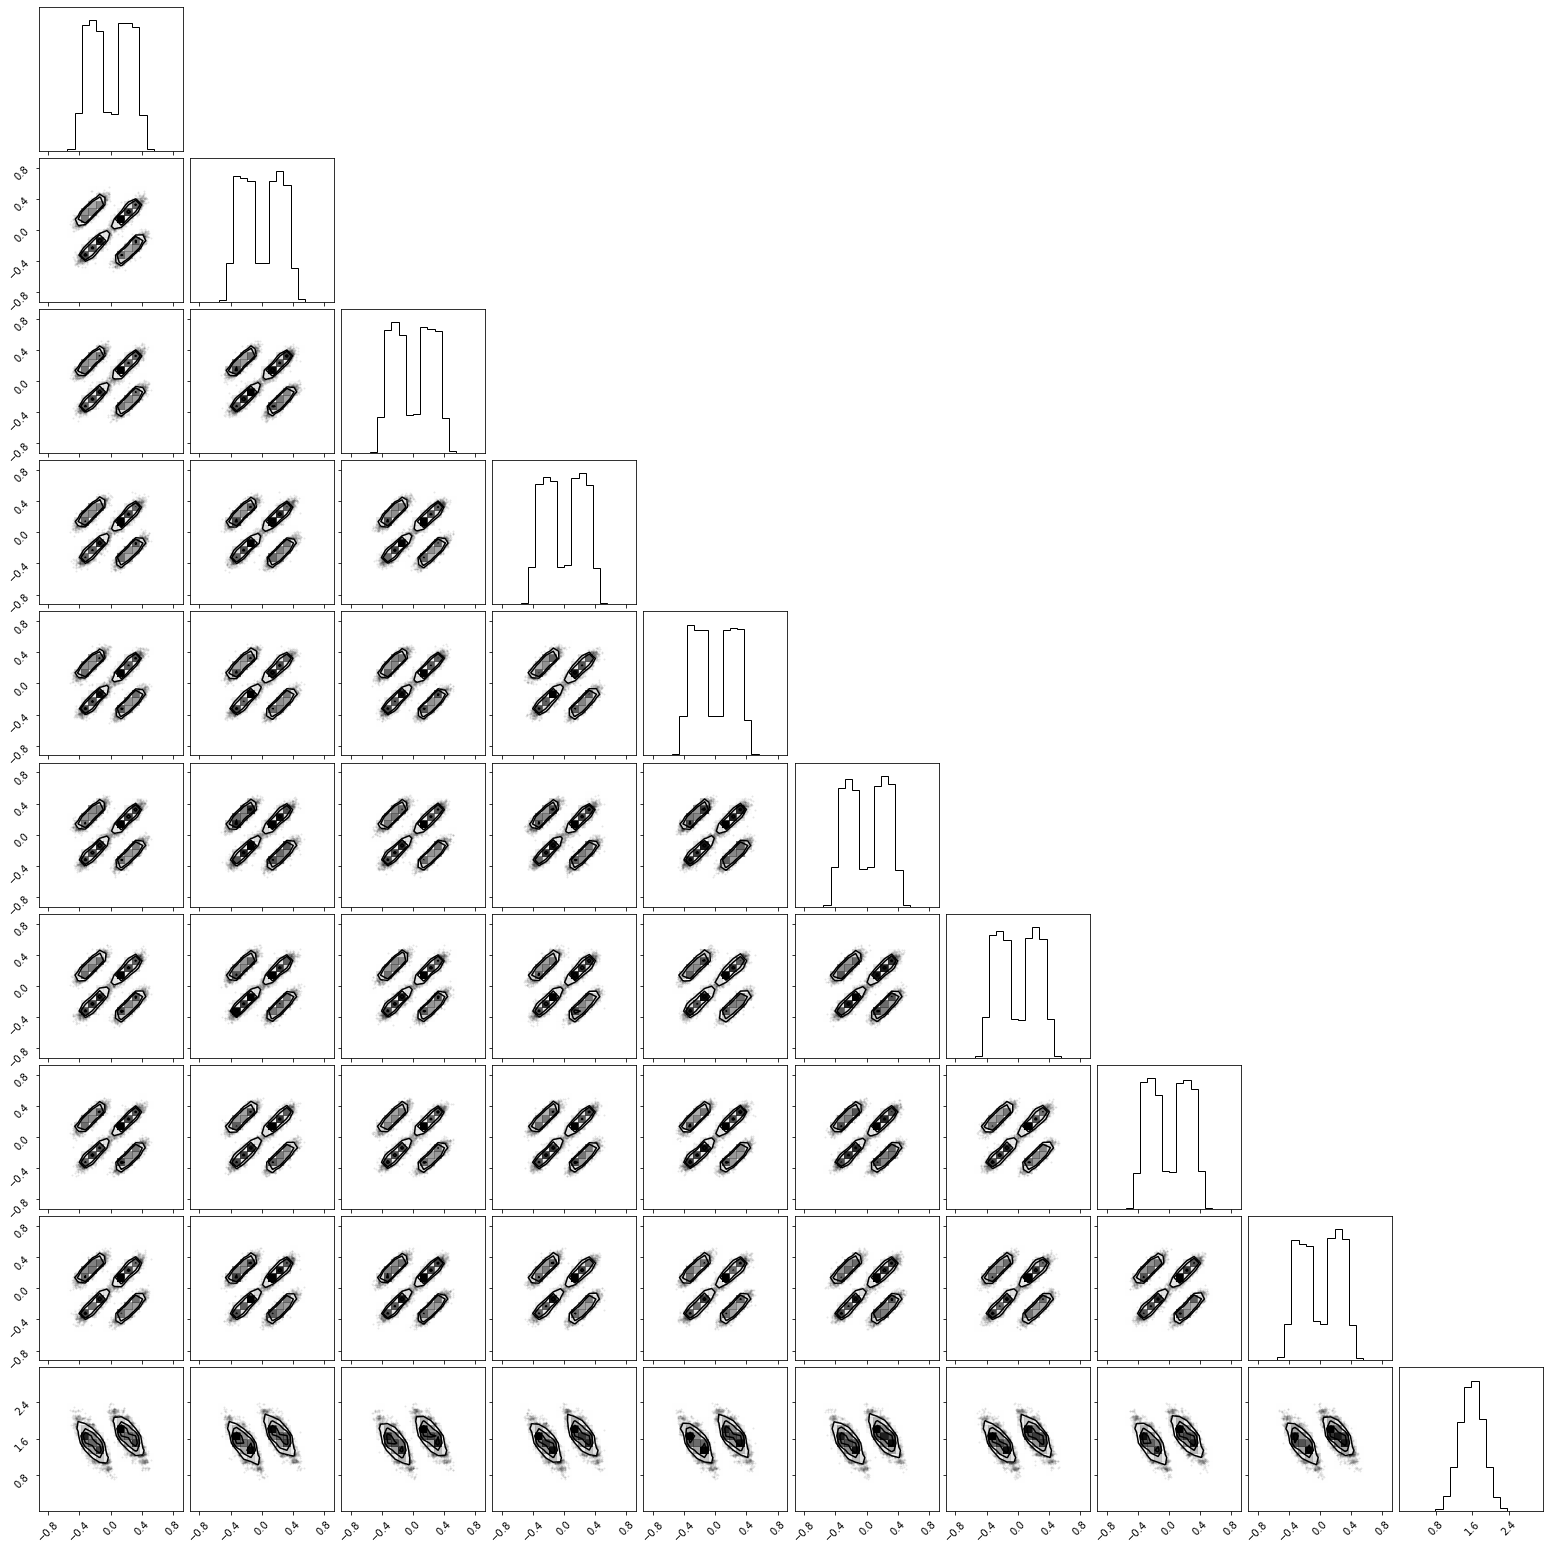

In [7]:
s = np.dot(ps, Q.T)
o = corner.corner(s, range=bounds)